# Project : Autoencoder on occcluded Gaussians

### Brief Project Description
In this project, we build an CNN based autoencoder capable of removing occlusions on Gaussians. To achieve our goal, we create two datasets consisting of images of a two-dimensional Gaussian distribution. The images in both datasets are almost the same but differ in one single aspect. In one dataset, we artificially introduce occlusions consisting of random bars, whereas in the other dataset, the images remain in their original state without introducing occlusions. Next, we construct a CNN autoencoder with an architecture designed to remove occlusions on Gaussians. Finally, we evaluate and visualize the results obtained from our model.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# model summary info
from torchsummary import summary

import copy

## Create the Gaussian Datasets

In [49]:
nGauss = 1000
imgSize = 91
x = np.linspace(-4,4,imgSize)

# Create a rectangular grid out of the array x
X, Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20, nGauss)

# initialize tensor containing images
imagesRandomBar = torch.zeros(nGauss,1,imgSize,imgSize)
imagesNoRandomBar = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):
    
    # create the gaussian with random centers
    ro = 1.5*np.random.rand(2)
    GNoRandomBar = np.exp(  -((X-ro[0])**2+(Y-ro[1])**2) / widths[i])
    
    # and add noise
    GNoRandomBar = GNoRandomBar + np.random.randn(imgSize,imgSize)/5
    
    # Make a copy of the Gaussian to add some occlusions
    GRandomBar = copy.deepcopy(GNoRandomBar)
    
    # add a ramdom bar randomly
    i1 = np.random.choice(np.arange(2,28))
    i2 = np.random.choice(np.arange(2,6))
    
    if np.random.rand()>0:
        GRandomBar [i1:i1+i2,] = 1
    else:
        GRandomBar[:,i1:i1+i2] = 1
        
    # add to the tensors
    imagesRandomBar[i,:,:,:] = torch.Tensor(GRandomBar).view(1, imgSize, imgSize)
    imagesNoRandomBar[i,:,:,:] = torch.Tensor(GNoRandomBar).view(1, imgSize, imgSize)

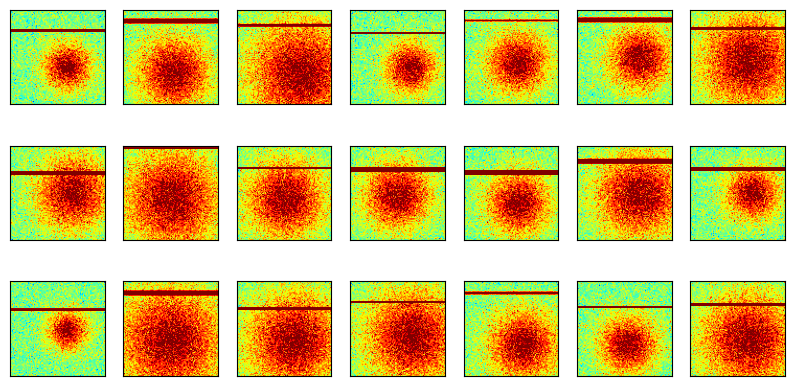

In [50]:
# Plot images with bars
fig, axs = plt.subplots(3,7,figsize=(10,5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    GRandomBar = np.squeeze(imagesRandomBar[whichpic,:,:])
    ax.imshow(GRandomBar,vmin=-1,vmax=1,cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

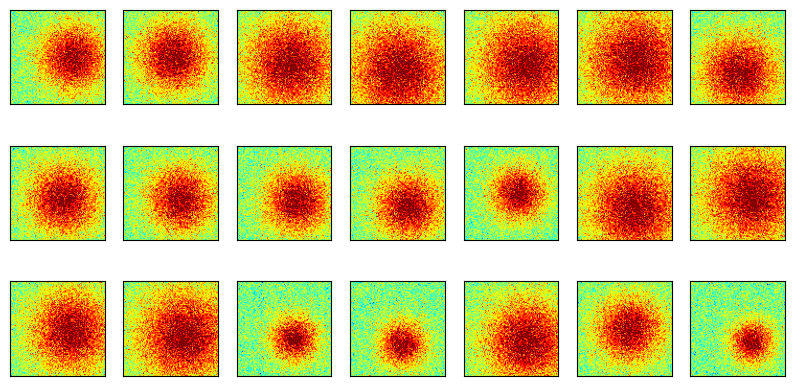

In [51]:
# Plot images with no bars
fig, axs = plt.subplots(3,7,figsize=(10,5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(imagesNoRandomBar[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

# Create the DL model

In [52]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)  
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer
                    

 
torch.Size([10, 1, 91, 91])


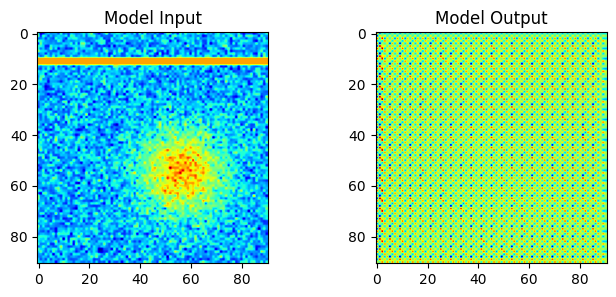

In [53]:
# test the model with one batch
net, lossfunb, optmizer = makeTheNet()

yHat = net(imagesRandomBar[:10,:,:,:])

# check the size of the output
print(' ')
print(yHat.shape)

# lets see howw they look
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(imagesRandomBar[0,0,:,:].detach(),cmap='jet')
ax[0].set_title('Model Input')
ax[1].imshow(yHat[0,0,:,:].detach(), cmap='jet')
ax[1].set_title('Model Output')

plt.show()

In [54]:
# count the totaal number of parameters of the model
summary(net,(1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

## Create a Function that Trains the Model

In [55]:
def trainTheModel():
    
    # number of epochs
    numepochs = 1000
    
    # create a new model
    net, lossfun, optimizer = makeTheNet()
    
    # initialize losses
    losses = torch.zeros(numepochs)
    
    # loop over training epochs
    for epochi in range(numepochs):
        
        # pick a set of images
        pic2use = np.random.choice(nGauss, size=32, replace=32)
        
        X_Bar = imagesRandomBar[pic2use,:,:,:]
        X_NoBar = imagesNoRandomBar[pic2use,:,:,:]
        
        # forward pass and loss
        yHat = net(X_Bar)
        loss = lossfun(yHat,X_NoBar)
        losses[epochi] = loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
      # end epochs
    
    return losses, net
        
        

## Evaluate the Model

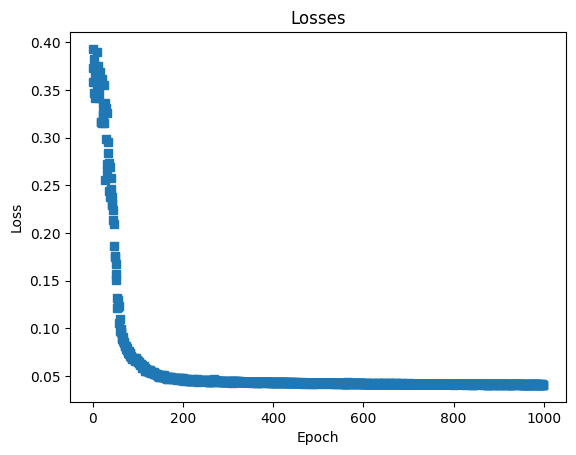

In [56]:
losses, net = trainTheModel()

# print losses
plt.plot(losses.detach(),'s')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

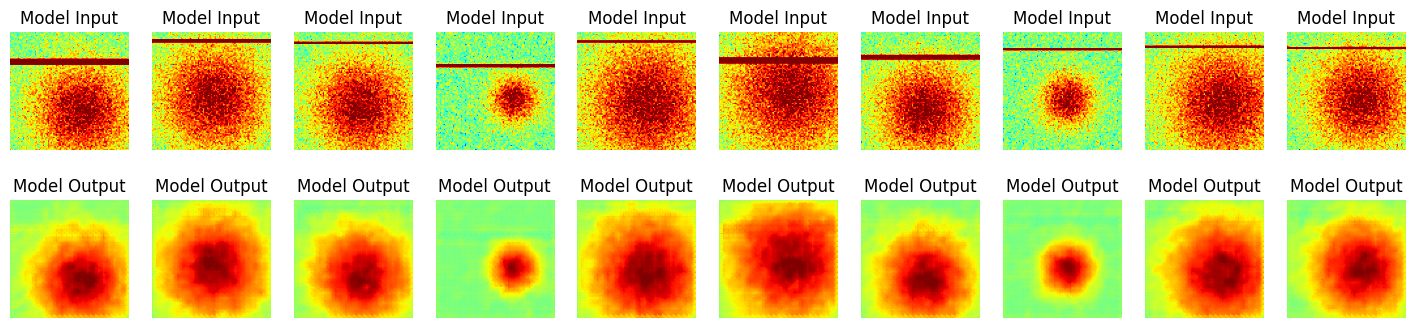

In [57]:
# Pick some images randomly
pic2use = np.random.choice(nGauss, size=32, replace=False)
X_Bar = imagesRandomBar[pic2use,:,:,:]

# Prediction for the imagess with bars
yHat = net(X_Bar)

# Plot some predicted images
fig, ax = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
    
    G = torch.squeeze(X_Bar[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()
    
    ax[0,i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax[0,i].axis('off')
    ax[0,i].set_title('Model Input')
    
    #ax[1,i].imshow(O, cmap='jet')
    ax[1,i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    ax[1,i].axis('off')
    ax[1,i].set_title('Model Output')

plt.show()

## References:

https://www.udemy.com/course/deeplearning_x/